In [12]:
from scipy.stats import norm, t, chi2, kstwobign, uniform, f 
from scipy import stats
from math import sqrt, ceil, floor
#---
import numpy as np
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

In [14]:
def CI(X, alph, sigma2, eps, flg):
    n = len(X)
    if flg==1: 
        mom1, tau = sum(X)/n, norm.ppf(1-eps/2)
        return [mom1-tau*sqrt(sigma2/n), mom1+tau*sqrt(sigma2/n)], mom1, tau
    elif flg==2:
        S21, g1, g2 = sum([(x-alph)**2 for x in X])/n, chi2.ppf(eps/2, n), chi2.ppf(1-eps/2, n)
        return [n*S21/g2, n*S21/g1], S21, g1, g2
    elif flg==3:
        mom1, g1, g2 = sum(X)/n, chi2.ppf(eps/2, n-1), chi2.ppf(1-eps/2, n-1)
        S20 = sum([(x-mom1)**2 for x in X])/(n-1)
        return [(n-1)*S20/g2, (n-1)*S20/g1], mom1, g1, g2, S20
    else:
        mom1, c = sum(X)/n, stats.t.ppf(1-eps/2, n-1)
        S20 = sum([(x-mom1)**2 for x in X])/(n-1)
        return [mom1-c*sqrt(S20/n), mom1+c*sqrt(S20/n)], mom1, c, S20

In [15]:
def HT_UD(X, eps, k, flg):
    if flg==1: 
        n, C = len(X), kstwobign.ppf(1-eps)
        res, data1 = EmpCDF_Val(X)
        res, data1 = EmpCDF(data1, res)
        sup = max(abs(res-uniform.cdf(data1)))
        rho = sqrt(n)*sup
        if rho<C: return True, C, sup, rho
        else: return False, C, sup, rho
    else:
        np, rho, C = len(X)/k, 0, chi2.ppf(1-eps, k-1)
        for j in range(1, k+1):rho+=(len([x for x in X if x>=(j-1)/k and x<j/k])-np)**2/np
        if rho<C: return True, C, rho
        else: return False, C, rho

In [16]:
def HT_UC(X, Y, eps, flg):
    n, m = len(X), len(Y)
    momX, momY = sum(X)/n, sum(Y)/m
    S02X, S02Y = sum([(x-momX)**2 for x in X])/(n-1), sum([(y-momY)**2 for y in Y])/(m-1)
    if flg==1:
        rho, g1, g2 = (n*(m-1)/(m*(n-1)))*S02X/S02Y, f.ppf(eps/2, n-1, m-1), f.ppf(1-eps/2, n-1, m-1)
        if g1<rho and rho<g2: return True, momX, momY, S02X, S02Y, rho, g1, g2
        else: return False, momX, momY, S02X, S02Y, g1, g2
    else:
        rho, C = sqrt(n*m/(n+m))*(momX-momY)/sqrt(((n-1)*S02X+(m-1)*S02Y)/(n+m-2)), t.ppf(1-(eps)/2, n+m-2)
        if abs(rho)<C: return True, momX, momY, S02X, S02Y, rho, C
        else: return False, momX, momY, S02X, S02Y, rho, C

In [17]:
def EmpCDF_Val(DATA):
    data1, s = list(set(DATA)), len(DATA)
    data1.sort()
    return [len([d for d in DATA if d<=data1[i]])/s for i in range(len(data1))], data1

In [18]:
def EmpCDF(DATA, RES, eps=0.0001):
    NODS = [DATA[0]]+[DATA[ceil(i/2)]-eps*(i%2!=0) for i in range(1, len(DATA)*2-2)]+[DATA[len(DATA)-1]]
    VALS = [RES[floor(i/2)] for i in range(len(DATA)*2-1)]
    return VALS, NODS

In [19]:
def SHOW(DATA, alph, sigmasq, eps, k=5, n=20, m=30):
    DATA1, DATA2, DATA = DATA[0:n], DATA[n:n+m], DATA[m+n:len(DATA)]
    s = len(DATA)
    print("___________________________")
    print("TASK1: Confidence Interval")
    print("___________________________")
    print("DATA:", "\n", DATA1+DATA2)
    print("---------------------------")
    print("a, sigma^2=", sigmasq)
    print("---------------------------")
    sol = CI(DATA1+DATA2, alph, sigmasq, eps, 1)
    print("Sample_Mean: ", sol[1], "; Quantile: ", sol[2], ";")
    print("CI: ", sol[0])
    print("---------------------------")
    print("sigma^2, a=", alph)
    print("---------------------------")
    sol = CI(DATA1+DATA2, alph, sigmasq, eps,2)
    print("Sample_Variance: ", sol[1], "; \nQuantile1: ", sol[2], "; Quantile2: ", sol[3], ";")
    print("CI: ", sol[0])
    print("---------------------------")
    print("sigma^2, a=?")
    print("---------------------------")
    sol = CI(DATA1+DATA2, alph, sigmasq, eps,3)
    print("Sample_Mean: ", sol[1], "; Unbiased_Sample_Variance: ", sol[4], 
          "; \nQuantile1: ", sol[2], "; Quantile2: ", sol[3], ";")
    print("CI: ", sol[0])
    print("---------------------------")
    print("a, sigma^2=?")
    print("---------------------------")
    sol = CI(DATA1+DATA2, alph, sigmasq, eps, 4)
    print("Sample_Mean: ", sol[1], "; Unbiased_Sample_Variance: ", sol[3], "; \nQuantile: ", sol[2], ";")
    print("CI: ", sol[0])
    print("___________________________")
    print("TASK2: The Hypothesis of Uniform Distribution")
    print("___________________________")
    print("DATA:", "\n", DATA)
    print("---------------------------")
    print("Kolmogorov–Smirnov test")
    print("---------------------------")
    sol = HT_UD(DATA, eps, k, 1)
    res, data1 = EmpCDF_Val(DATA)
    res, data1 = EmpCDF(data1, res)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(data1, res, color='red', label='Empirical')
    ax.plot(data1, uniform.cdf(data1), 'k--', linewidth=1.5, label='Theoretical')
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Empirical and Theoretical CDF')
    plt.show()
    print("Supremum: ", sol[2], "; Rho: ", sol[3], "; Quantile: ", sol[1], ";")
    print("SOL: ", sol[0])
    print("---------------------------")
    print("Chi-Squared test")
    print("---------------------------")
    sol = HT_UD(DATA, eps, k, 2)
    print("Rho: ", sol[2], "; Quantile: ", sol[1], ";")
    print("SOL: ", sol[0])
    print("___________________________")
    print("TASK3: The Hypothesis of Homogeneity of Distributions")
    print("___________________________")
    print("DATA_X:", "\n", DATA1)
    print("DATA_Y:", "\n", DATA2)
    sol = HT_UC(DATA1, DATA2, eps, 1)
    print("\nSample_Mean_X: ", sol[1], "; Sample_Mean_Y: ", sol[2], 
          "; \nUnbiased_Sample_Variance_X: ", sol[3], "; Unbiased_Sample_Variance_Y: ", sol[4], ";")
    print("---------------------------")
    print("F-test")
    print("---------------------------")
    print("Rho: ", sol[5], "; \nQuantile1: ", sol[6], "; Quantile2: ", sol[7], ";")
    print("SOL: ", sol[0])
    print("---------------------------")
    print("t-test")
    print("---------------------------")
    sol = HT_UC(DATA1, DATA2, eps, 2)
    print("Rho: ", sol[5], "; Quantile1: ", sol[6], ";")
    print("SOL: ", sol[0])

___________________________
TASK1: Confidence Interval
___________________________
DATA: 
 [-0.929, -0.378, -1.741, -0.475, -0.66, -1.04, 0.054, -1.459, -0.624, -1.114, 0.385, -0.211, -0.41, -1.42, -0.75, 0.394, -1.25, -1.548, -2.938, -0.466, -1.912, 0.146, -0.841, -0.327, -1.163, -0.858, -1.441, -2.064, 0.585, -0.041, -1.863, -0.747, -2.007, -1.51, -0.463, -1.305, 0.508, -1.569, 0.292, -1.275, -0.084, -1.861, 0.405, -0.656, -2.964, -1.153, -1.769, -1.091, -0.736, -1.499]
---------------------------
a, sigma^2= 0.9
---------------------------
Sample_Mean:  -0.9168599999999999 ; Quantile:  1.81191067295 ;
CI:  [-1.1599533260327637, -0.67376667396723611]
---------------------------
sigma^2, a= -1.0
---------------------------
Sample_Variance:  0.6998377799999999 ; 
Quantile1:  33.4734113975 ; Quantile2:  69.562730917 ;
CI:  [0.50302638408146449, 1.045363694319724]
---------------------------
sigma^2, a=?
---------------------------
Sample_Mean:  -0.9168599999999999 ; Unbiased_Sample_Vari

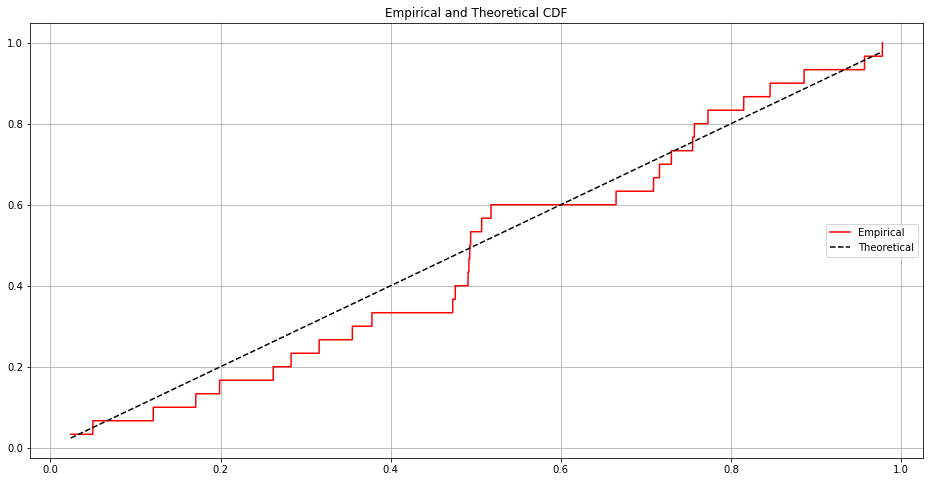

Supremum:  0.139566666667 ; Rho:  0.764438116091 ; Quantile:  1.29467454135 ;
SOL:  True
---------------------------
Chi-Squared test
---------------------------
Rho:  1.3333333333333335 ; Quantile:  8.66642823447 ;
SOL:  True
___________________________
TASK3: The Hypothesis of Homogeneity of Distributions
___________________________
DATA_X: 
 [-0.929, -0.378, -1.741, -0.475, -0.66, -1.04, 0.054, -1.459, -0.624, -1.114, 0.385, -0.211, -0.41, -1.42, -0.75, 0.394, -1.25, -1.548, -2.938, -0.466]
DATA_Y: 
 [-1.912, 0.146, -0.841, -0.327, -1.163, -0.858, -1.441, -2.064, 0.585, -0.041, -1.863, -0.747, -2.007, -1.51, -0.463, -1.305, 0.508, -1.569, 0.292, -1.275, -0.084, -1.861, 0.405, -0.656, -2.964, -1.153, -1.769, -1.091, -0.736, -1.499]

Sample_Mean_X:  -0.8290000000000001 ; Sample_Mean_Y:  -0.975433333333333 ; 
Unbiased_Sample_Variance_X:  0.6157771578947369 ; Unbiased_Sample_Variance_Y:  0.7823861160919541 ;
---------------------------
F-test
---------------------------
Rho:  0.80085810

In [20]:
data = [float(a.replace(",", ".")) for a in open(r"d:\LEARN\IN7.txt").read().split()]
SHOW(data, -1.0, 0.9, 0.07)